## All of the Imports

In [1]:
import re
import nltk

import pandas as pd
import numpy as np

from os import sep, makedirs
from os.path import dirname, realpath, join, isdir, exists
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams

from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score, f1_score, roc_curve, r2_score, mean_squared_error
from sklearn.cluster import KMeans
import scikitplot.plotters as skplt

from nltk.corpus import stopwords

import gensim
import itertools
import emoji
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import emotlib
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import folium
%matplotlib inline

## Loading the Data

In [2]:
uppath = lambda _path, n: sep.join(_path.split(sep)[:-n]) # moves the path 'n' levels up the directory

__file__ = dirname(realpath('__file__'))
data_parent_directory = uppath(__file__, 2)
data_directory = join(data_parent_directory, 'Data')
root_directory = join(data_directory, 'sea_ice')

In [3]:
def load_data(root_directory, file_name, encoding='utf-8', skiprows=0):
    file_path = join(root_directory, file_name)
    return pd.read_csv(file_path, encoding=encoding, skiprows=skiprows)

In [4]:
SeaIce = load_data(root_directory, 'seaice.csv')
SeaIce.head()

,Year,Month,Day,Extent,Missing,Source Data,hemisphere
0,1978,10,26,10.231,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
1,1978,10,28,10.420,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
2,1978,10,30,10.557,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
3,1978,11,1,10.670,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north
4,1978,11,3,10.777,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north


In [5]:
SeaIce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 7 columns):
Year            26354 non-null int64
 Month          26354 non-null int64
 Day            26354 non-null int64
     Extent     26354 non-null float64
    Missing     26354 non-null float64
 Source Data    26354 non-null object
hemisphere      26354 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB


Seems like the column names have unnecessary spaces. Let's remove them.

In [6]:
SeaIce.columns = ['year', 'month', 'day', 'extent', 'missing', 'source', 'hemisphere']
SeaIce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26354 entries, 0 to 26353
Data columns (total 7 columns):
year          26354 non-null int64
month         26354 non-null int64
day           26354 non-null int64
extent        26354 non-null float64
missing       26354 non-null float64
source        26354 non-null object
hemisphere    26354 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 1.4+ MB


In [7]:
SeaIce.describe()

,year,month,day,extent,missing
count,26354.000000,26354.000000,26354.000000,26354.000000,26354.000000
mean,2000.591941,6.507399,15.740685,11.494986,0.000003
std,10.896821,3.451938,8.801607,4.611734,0.000227
min,1978.000000,1.000000,1.000000,2.080000,0.000000
25%,1992.000000,4.000000,8.000000,7.601000,0.000000
50%,2001.000000,7.000000,16.000000,12.217000,0.000000
75%,2010.000000,10.000000,23.000000,15.114000,0.000000
max,2019.000000,12.000000,31.000000,20.201000,0.024000


In [8]:
SeaIce['date'] = pd.to_datetime(SeaIce[['day', 'month','year']])
SeaIce.head()

,year,month,day,extent,missing,source,hemisphere,date
0,1978,10,26,10.231,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north,1978-10-26
1,1978,10,28,10.420,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north,1978-10-28
2,1978,10,30,10.557,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north,1978-10-30
3,1978,11,1,10.670,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north,1978-11-01
4,1978,11,3,10.777,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,north,1978-11-03


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025424F6CE48>],
      dtype=object)

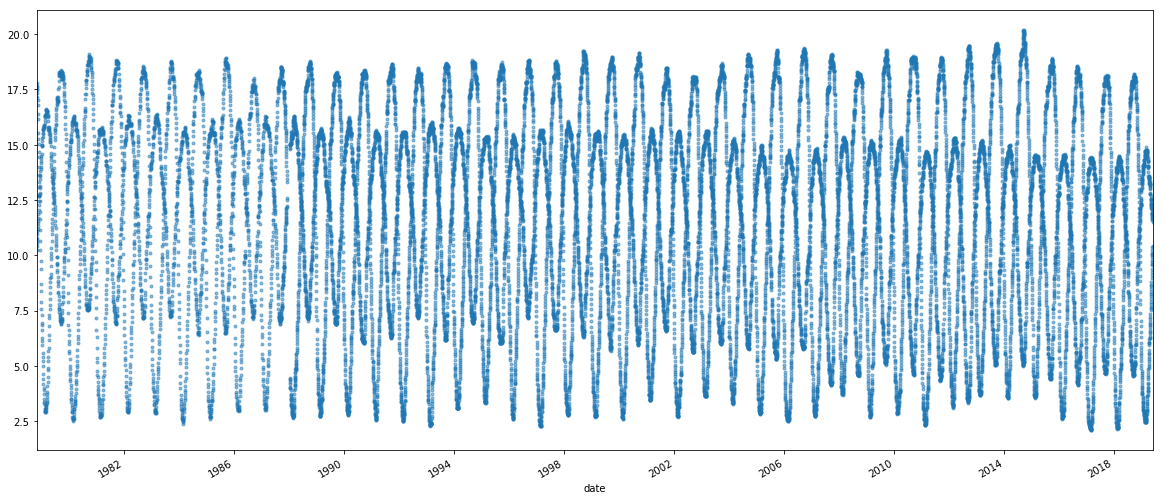

In [9]:
sea_copy = SeaIce.set_index('date')
sea_copy['extent'].plot(marker='.', alpha=0.5, linestyle='None', figsize=(20, 9), subplots=True)

<ul>
<li>The Sea Ice extent is pretty wavy, like a periodic sine wave. The pattern repeats for every year, indicating Seasonality.</li>
<li>Seasonality is probably due to alternate melting and freezing during summer and winter seasons respectively.</li>
<li>There seem to be two waves. I'm guessing one for each hemisphere. They clearly have a lag.</li>
</ul>

In [10]:
SeaIce['hemisphere'].value_counts()
# SeaIce['date'].value_counts()

south    13177
north    13177
Name: hemisphere, dtype: int64

In [11]:
north = sea_copy[sea_copy['hemisphere'] == 'north'].copy()
south = sea_copy[sea_copy['hemisphere'] == 'south'].copy()

Every date is repeated twice. And data on each hemisphere is exactly equal.

## Visualizations

In [12]:
from IPython.display import HTML
from IPython.display import display

''' The JS code to handle toggle event '''
def create_hide_handler():
    
    return HTML('''
    <script> 
        function code_toggle(event) {
             
             button = $(event.currentTarget); 
             input = button.parents('.cell').find('.input');

             if (input.is(':visible')){
                 button[0].value = "Code";
                 input.hide();
             } else {
                 button[0].value = "Hide";
                 input.show();
             }
        }
    </script>
    ''')


# The button used for toggling a cell
# Note: Use display(toggle_input()) to show the button. This will embed the button into the page's HTML.
# Take the example cell:- 
#    toggle_input()
#    train.head()
# This will only execute the last line, so the button won't display. Hence the display function.
def toggle_input():
    return HTML('''
    <input type="button" value="Hide/Show" onclick="javascript:code_toggle(event)" style="background:transparent;border:1px solid black;float:right">
    ''')

# Add the handler JS code to the page. Adding once is enough.
create_hide_handler()
toggle_input()

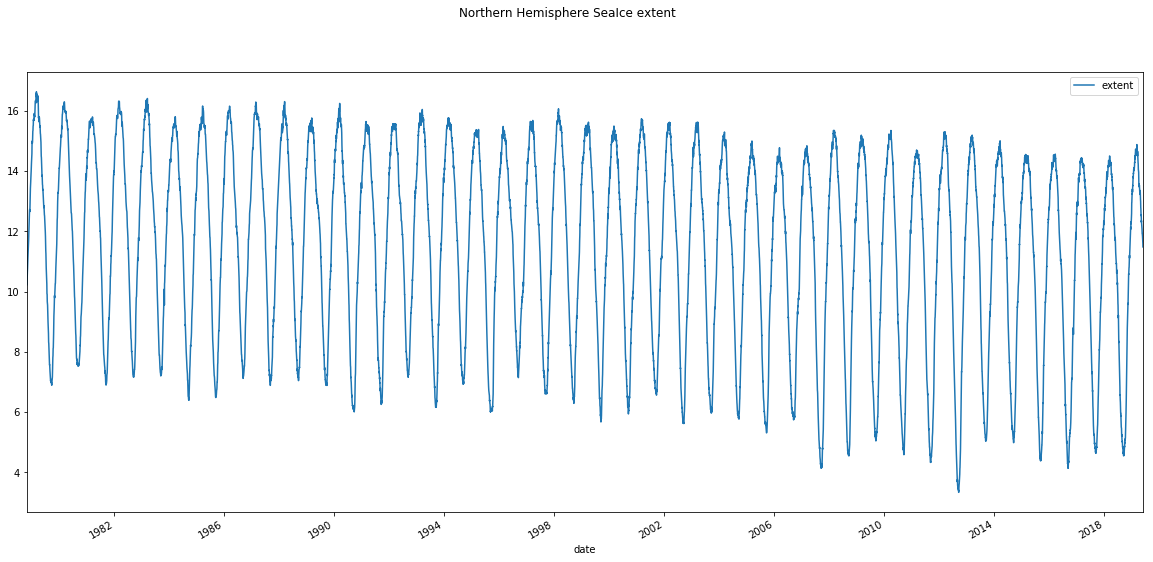

In [13]:
north.plot(y='extent', figsize=(20, 9), subplots=True, title='Northern Hemisphere SeaIce extent')
toggle_input()

The Northern Hemisphere seems to have a slight trend. It slightly dips towards the end.

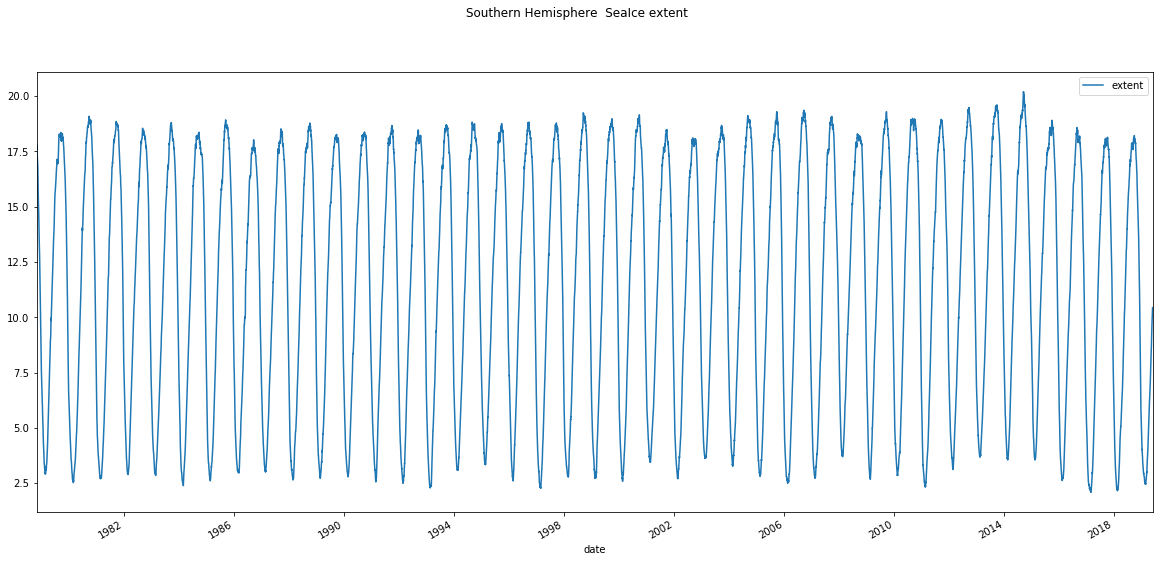

In [14]:
south.plot(y='extent', figsize=(20, 9), subplots=True, title='Southern Hemisphere  SeaIce extent')
toggle_input()

The Southern hemisphere series doesn't seem to have much of a trend.
<br>From first impression, it seems like Northern Hemispherean Sea Ice has taken a bigger hit. Let's see.

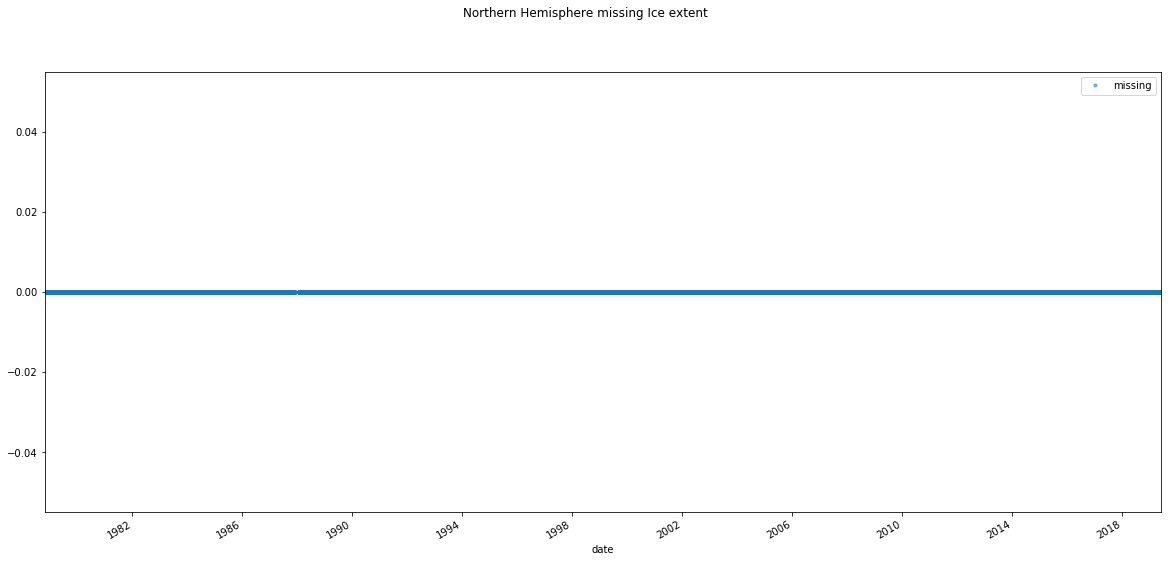

In [15]:
north.plot(y='missing', marker='.', alpha=0.5, linestyle='None', figsize=(20, 9), subplots=True, title='Northern Hemisphere missing Ice extent')
toggle_input()

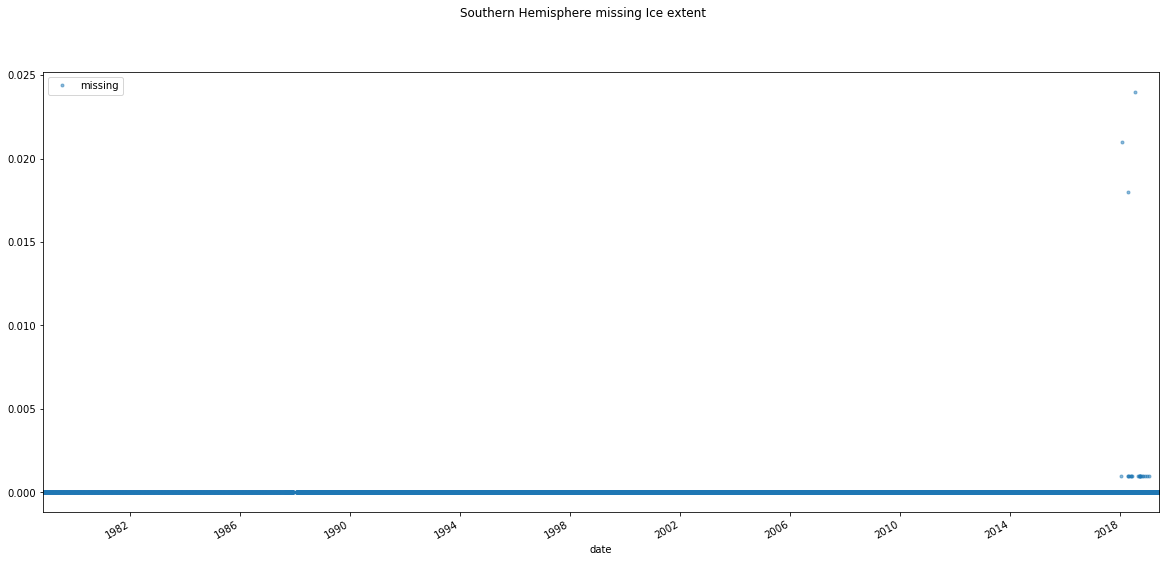

In [16]:
south.plot(y='missing', marker='.', alpha=0.5, linestyle='None', figsize=(20, 9), subplots=True, title='Southern Hemisphere missing Ice extent')
toggle_input()

But wait, this is weird. This seems to show that some parts of the Southern Hemispherean Sea Ice has gone missing in recent years, but the Northern Hemisphere is fine. That's seems to be the opposite of previous visualization!

In [17]:
north_monthly = north['extent'].resample('MS').mean()
south_monthly = south['extent'].resample('MS').mean()

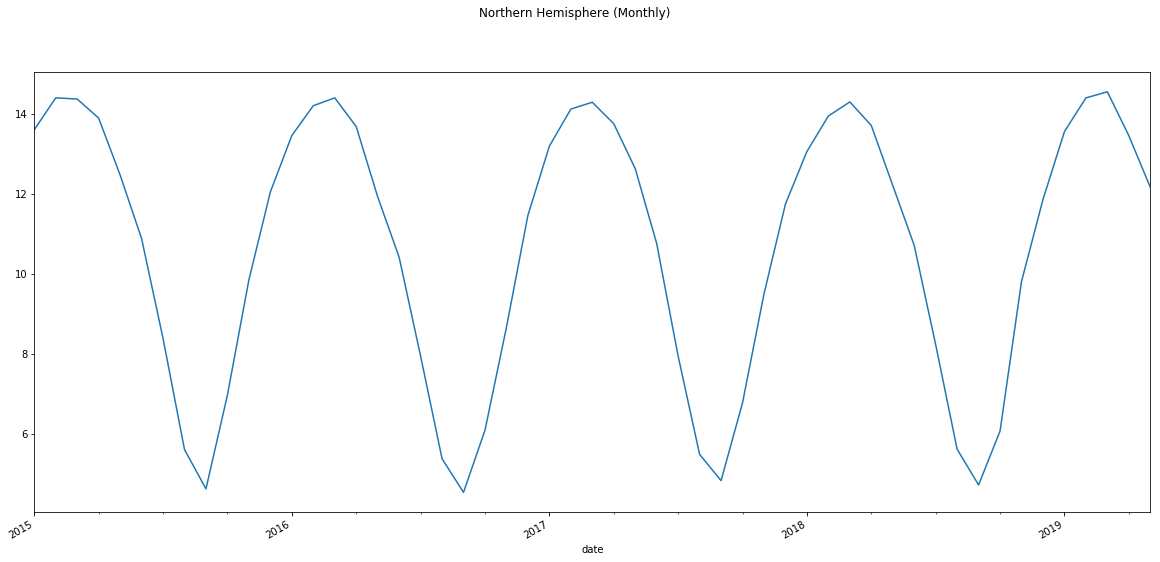

In [18]:
north_monthly['2015':].plot(y='extent', figsize=(20, 9), subplots=True, title='Northern Hemisphere (Monthly)')
toggle_input()

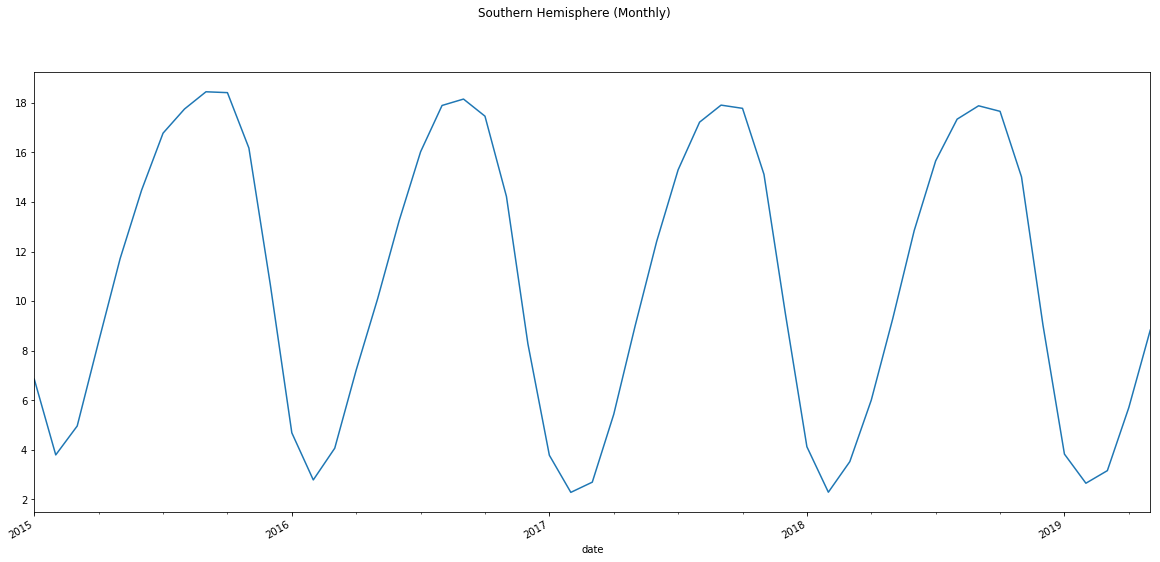

In [19]:
south_monthly['2015':].plot(y='extent',figsize=(20, 9), subplots=True, title='Southern Hemisphere (Monthly)')
toggle_input()

Let's visualize the seasonal, trend and residual decompositions of each hemispheres.

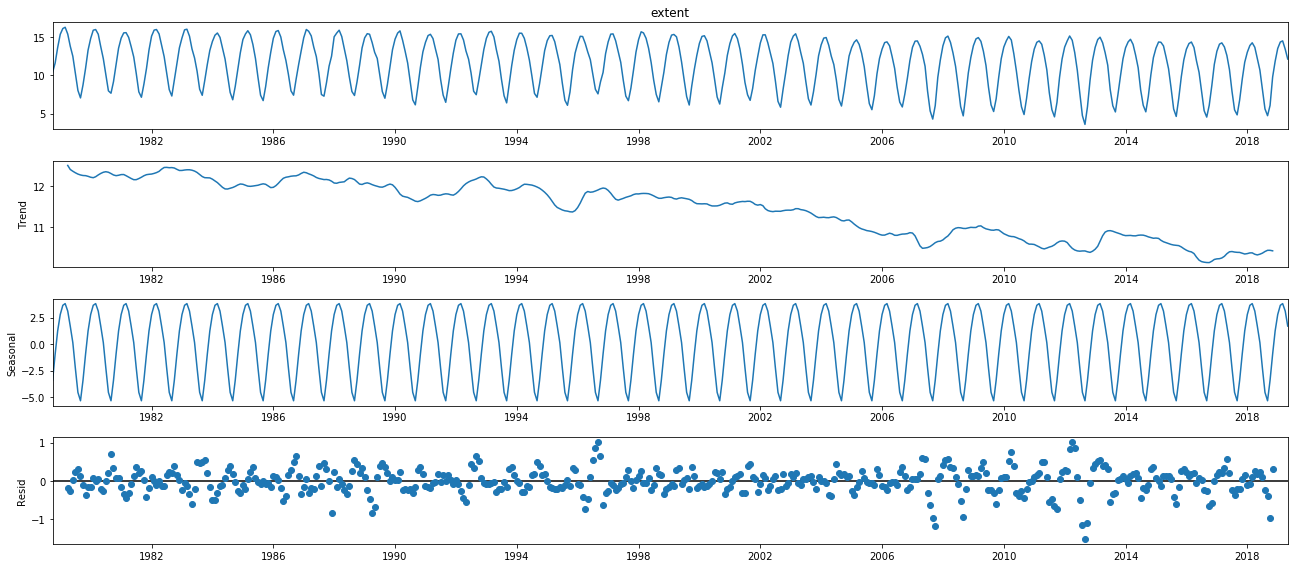

In [20]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(north_monthly, model='additive')
fig = decomposition.plot()
plt.show()

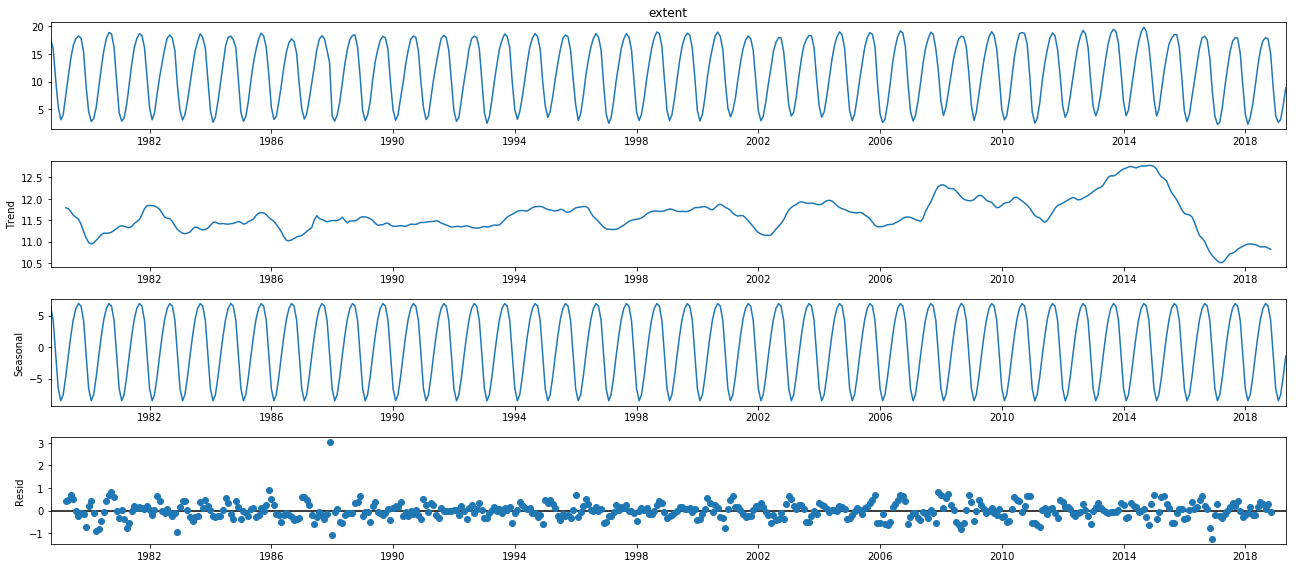

In [21]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(south_monthly, model='additive')
fig = decomposition.plot()
plt.show()

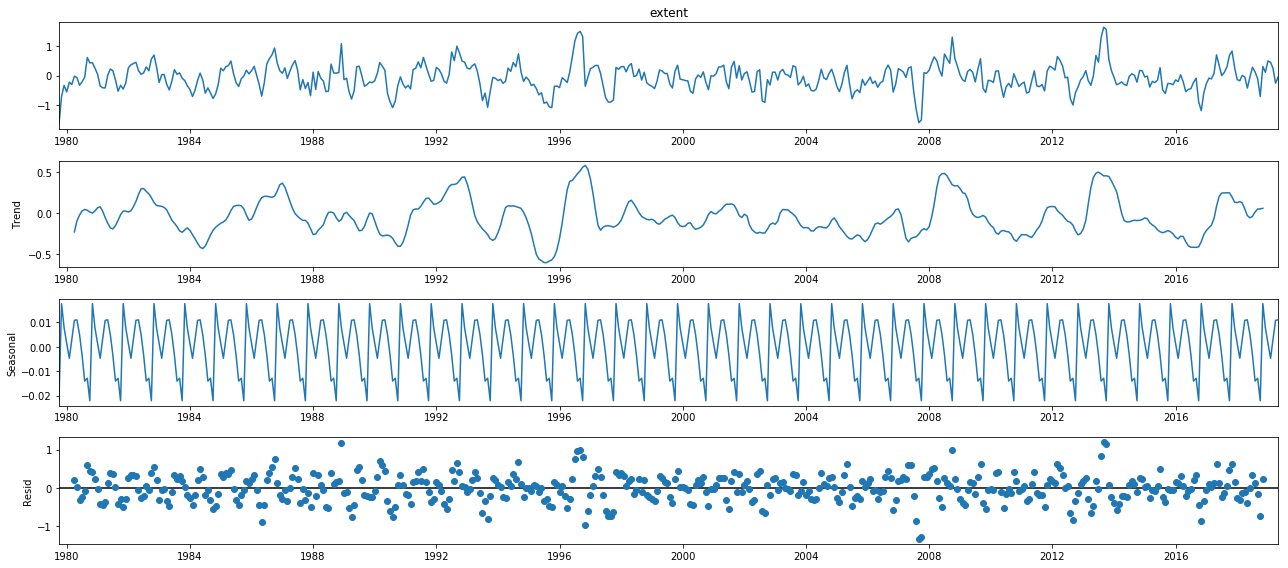

In [22]:
unseasoned_north = (north_monthly.dropna() - north_monthly.dropna().shift(12)).dropna()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(unseasoned_north, model='additive')
fig = decomposition.plot()
plt.show()

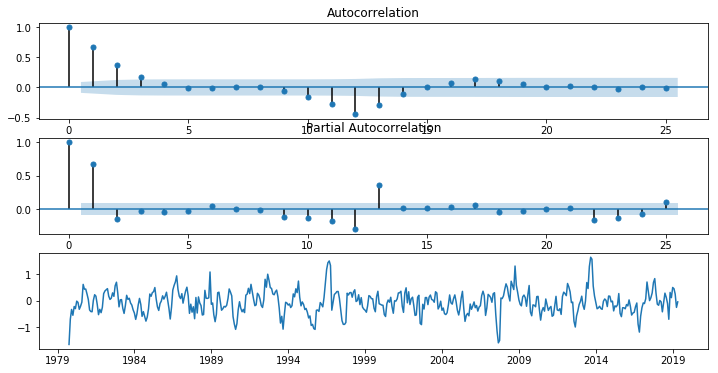

In [23]:
fig, ax = plt.subplots(3, figsize=(12,6))
ax[0] = plot_acf(unseasoned_north, ax=ax[0], lags=25)
ax[1] = plot_pacf(unseasoned_north, ax=ax[1], lags=25)
ax[2].plot(unseasoned_north)

In [24]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(north_monthly)
print(pvalue)

0.7433042931743168


In [25]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(unseasoned_north)
print(pvalue)

2.210539530526869e-08


The series is Stationary. No need to do first differencing.

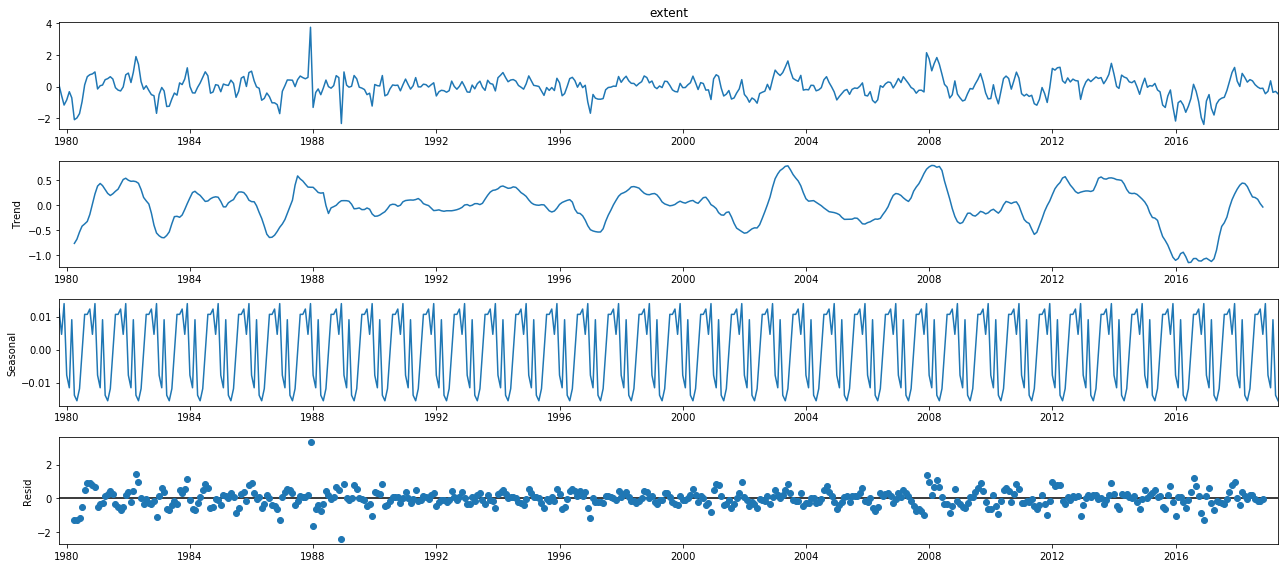

In [26]:
unseasoned_south = (south_monthly.dropna() - south_monthly.dropna().shift(12)).dropna()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(unseasoned_south, model='additive')
fig = decomposition.plot()
plt.show()

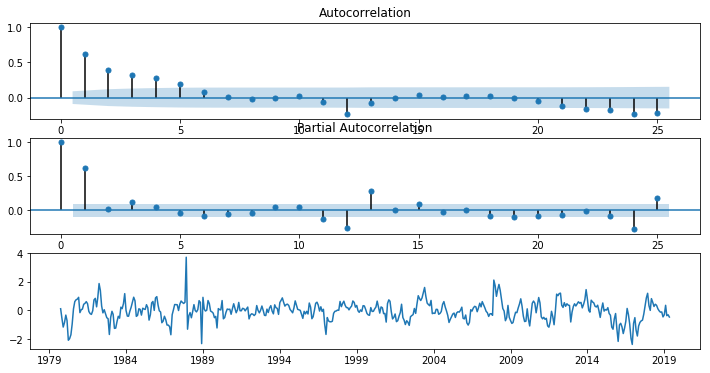

In [27]:
fig, ax = plt.subplots(3, figsize=(12,6))
ax[0] = plot_acf(unseasoned_south, ax=ax[0], lags=25)
ax[1] = plot_pacf(unseasoned_south, ax=ax[1], lags=25)
ax[2].plot(unseasoned_south)

In [28]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(south_monthly)
print(pvalue)

0.00873337994589948


In [29]:
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(unseasoned_south)
print(pvalue)

2.6445072893783147e-05


The Series was already pretty stationary. Hence no need to perform first differencing.

---

I guessed the order based on the ACF and PACF graphs plotted earlier.
<br>But I've also played around with a few other values and selected the combination with the least AIC.

In [30]:
north_model = sm.tsa.statespace.SARIMAX(north_monthly,
                                order=(2, 0, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
north_results = north_model.fit()
print(north_results.summary().tables[1])
print('AIC: ', north_results.aic)

C:\Users\AVINASH AKELLA\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6097      0.048     33.732      0.000       1.516       1.703
ar.L2         -0.6093      0.047    -12.831      0.000      -0.702      -0.516
ma.L1         -0.7354      0.077     -9.516      0.000      -0.887      -0.584
ma.L2         -0.2658      0.059     -4.540      0.000      -0.381      -0.151
ar.S.L12      -0.5278      0.347     -1.521      0.128      -1.208       0.152
ar.S.L24    5.118e-05      0.003      0.015      0.988      -0.007       0.007
ma.S.L12      -0.3562      0.358     -0.995      0.320      -1.058       0.345
ma.S.L24      -0.3432      0.303     -1.131      0.258      -0.938       0.252
sigma2         0.0613      0.006      9.479      0.000       0.049       0.074
AIC:  53.428341612601024


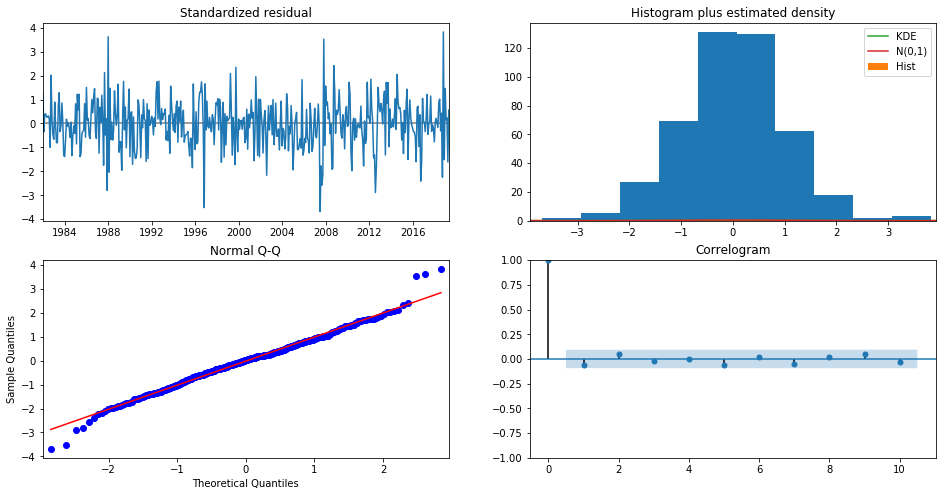

In [31]:
north_results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [32]:
north_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             extent   No. Observations:                  488
Model:             SARIMAX(2, 0, 2)x(2, 1, 2, 12)   Log Likelihood                 -17.714
Date:                            Sat, 12 Sep 2020   AIC                             53.428
Time:                                    21:55:17   BIC                             90.392
Sample:                                10-01-1978   HQIC                            67.998
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6097      0.048     33.732      0.000       1.516       1.703
ar.L2         -0.6093      0.047    -12.831      0.000      -0.702      -0.516
ma.L1         -0.7354      0.077     -9.516      0.000      -0.887      -0.584
ma.L2         -0.2658      0.059     -4.540      0.000      -0.381      -0.151
ar.S.L12      -0.5278      0.347     -1.521      0.128      -1.208       0.152
ar.S.L24    5.118e-05      0.003      0.015      0.988      -0.007       0.007
ma.S.L12      -0.3562      0.358     -0.995      0.320      -1.058       0.345
ma.S.L24      -0.3432      0.303     -1.131      0.258      -0.938       0.252
sigma2         0.0613      0.006      9.479      0.000       0.049       0.074
===================================================================================
Ljung-Box (Q):                       41.42   Jarque-Bera (JB):                23.51
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                            -0.01
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
south_model = sm.tsa.statespace.SARIMAX(south_monthly,
                                order=(1, 0, 2),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
south_results = south_model.fit()
print(south_results.summary().tables[1])
print('AIC: ', south_results.aic)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9145      0.034     26.895      0.000       0.848       0.981
ma.L1         -0.3141      0.040     -7.908      0.000      -0.392      -0.236
ma.L2         -0.1764      0.062     -2.838      0.005      -0.298      -0.055
ar.S.L12       0.1062      0.055      1.930      0.054      -0.002       0.214
ar.S.L24      -0.1223      0.042     -2.899      0.004      -0.205      -0.040
ma.S.L12      -1.0000    394.976     -0.003      0.998    -775.139     773.139
sigma2         0.1483     58.558      0.003      0.998    -114.624     114.920
AIC:  477.0562689882269


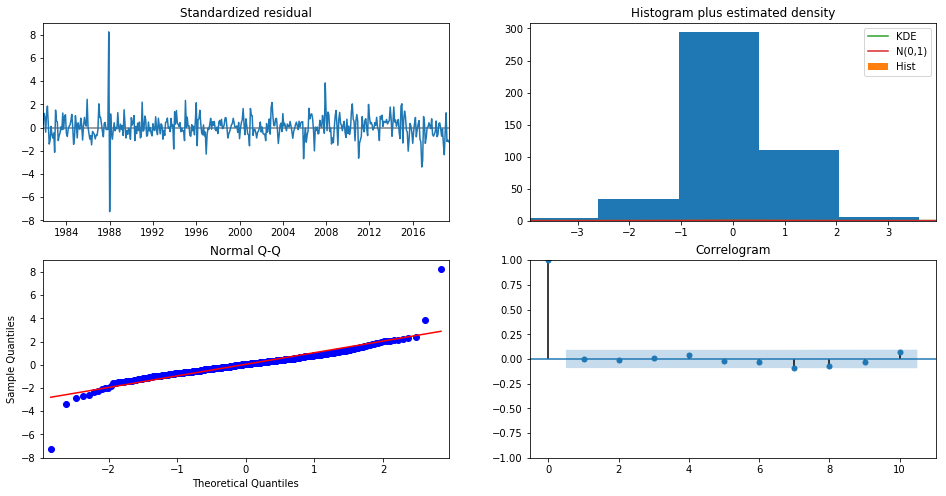

In [34]:
south_results.plot_diagnostics(figsize=(16, 8))
plt.show()

For both the models residuals seem insignificant, indicating that our models have done a good job.
<br>Let's also visualize this relationship, and see how they forecast.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002542A913470>],
      dtype=object)

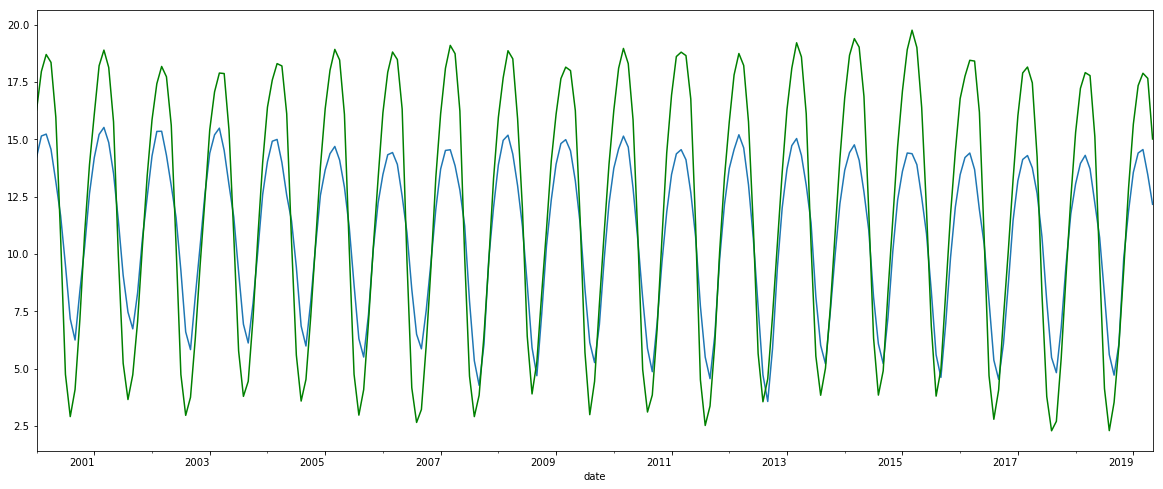

In [35]:
north_monthly['2000':].plot(figsize=(20, 9), subplots=True)
south_monthly.shift(6)['2000':].plot(figsize=(20, 9), subplots=True, color='green')

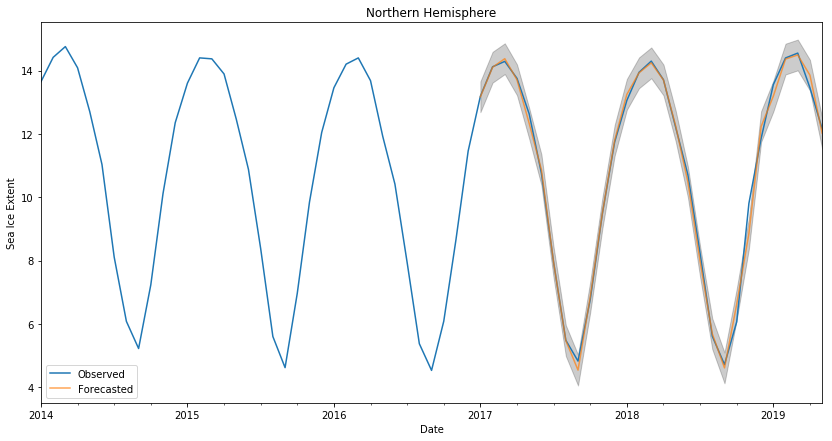

In [36]:
north_pred = north_results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = north_pred.conf_int()
ax = north_monthly['2014':].plot(label='Observed')
north_pred.predicted_mean.plot(ax=ax, label='Forecasted', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sea Ice Extent')
ax.set_title('Northern Hemisphere')
plt.legend()
plt.show()

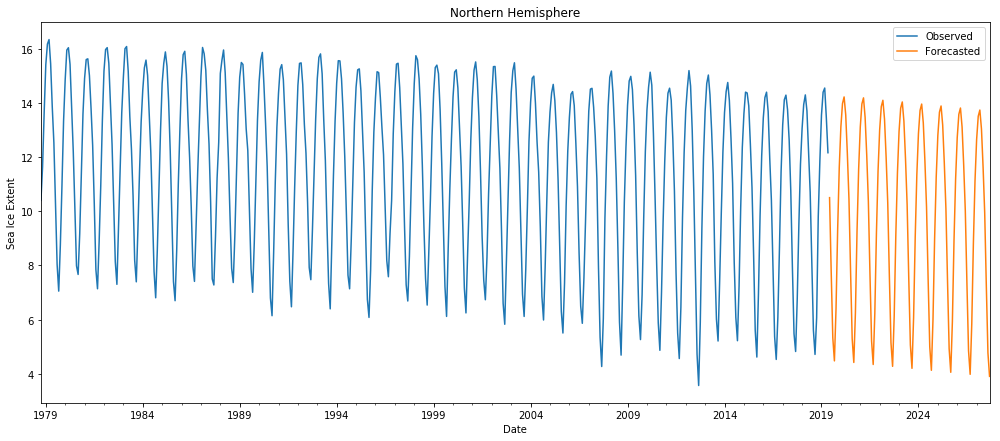

In [37]:
north_pred_uc = north_results.get_forecast(steps=100)
north_pred_ci = north_pred_uc.conf_int()
ax = north_monthly.plot(label='Observed', figsize=(17, 7))
north_pred_uc.predicted_mean.plot(ax=ax, label='Forecasted')

ax.set_xlabel('Date')
ax.set_ylabel('Sea Ice Extent')
ax.set_title('Northern Hemisphere')
plt.legend()
plt.show()

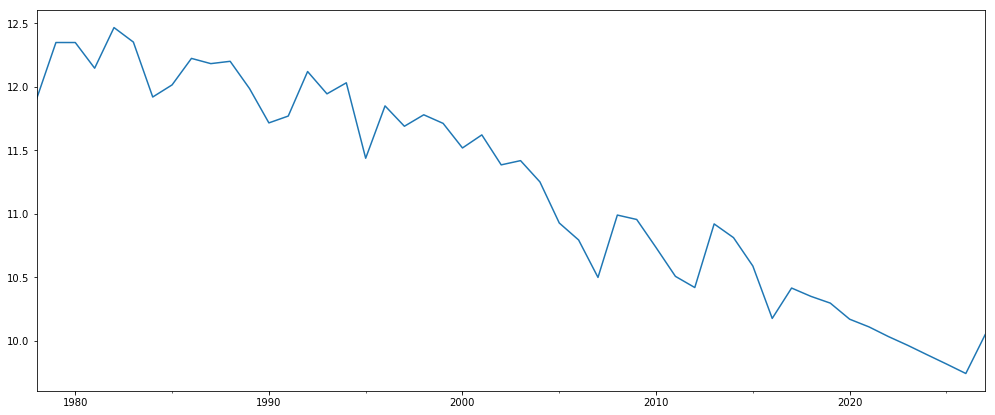

In [38]:
predicted_north = pd.concat([north_monthly, north_pred_uc.predicted_mean])
predicted_north.resample('Y').mean().plot(figsize=(17, 7))

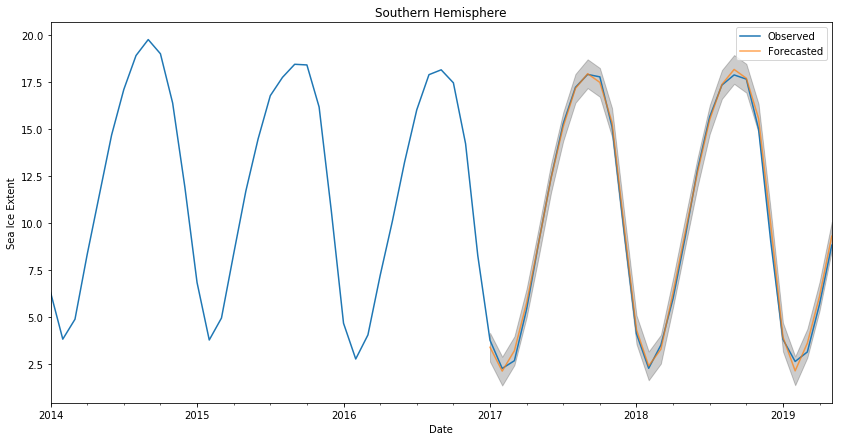

In [39]:
south_pred = south_results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
south_pred_ci = south_pred.conf_int()
ax = south_monthly['2014':].plot(label='Observed')
south_pred.predicted_mean.plot(ax=ax, label='Forecasted', alpha=.7, figsize=(14, 7))
ax.fill_between(south_pred_ci.index,
                south_pred_ci.iloc[:, 0],
                south_pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sea Ice Extent')
ax.set_title('Southern Hemisphere')
plt.legend()
plt.show()

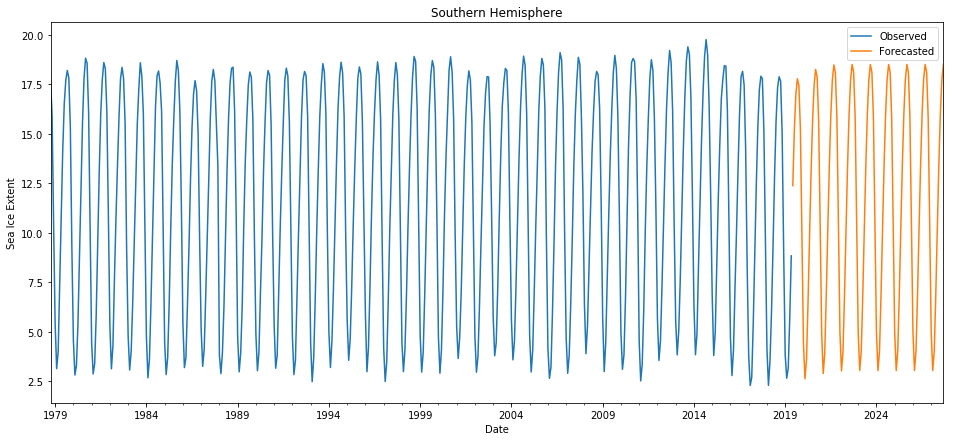

In [40]:
south_pred_uc = south_results.get_forecast(steps=100)
south_pred_ci = south_pred_uc.conf_int()
ax = south_monthly.plot(label='Observed', figsize=(16, 7))
south_pred_uc.predicted_mean.plot(ax=ax, label='Forecasted')

ax.set_xlabel('Date')
ax.set_ylabel('Sea Ice Extent')
ax.set_title('Southern Hemisphere')
plt.legend()
plt.show()

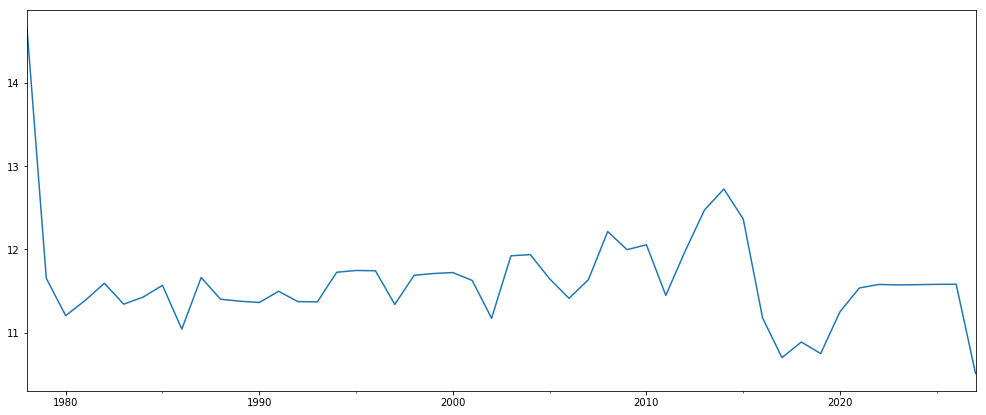

In [41]:
predicted_south = pd.concat([south_monthly, south_pred_uc.predicted_mean])
predicted_south.resample('Y').mean().plot(figsize=(17, 7))